Try indep sites on two different paths of the tree

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import adabmDCA
from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.functional import one_hot

import sys
sys.path.append('..')
import indep_sites, utils

/home/scrotti/Aptamer2025py/experiments/../indep_sites.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


File names for data

In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N", "R02F", "R02S", "R02SF"]

In [3]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


Extract sequences and compute 1st and 2nd moment statistics

In [4]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [5]:
ts = range(len(sequences))

In [6]:
alpha = 0.0
pseudo_count = alpha

In [7]:
freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[utils.frequences_from_sequences(seq, pseudo_count=pseudo_count, dtype=dtype) for seq in sequences])

In [8]:
fi = torch.stack(freq_single_tuple)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple)      # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple, dtype=dtype)

n_rounds, L, q = fi.size()

In [9]:
paths = [np.array([1, 2]), np.array([1, 3]), np.array([1, 4]), np.array([1, 5])]
n_paths = len(paths)
path_labels = ['norm A, norm W', 'fast A, norm W', 'norm A, high W', 'fast A, high W']

In [10]:
fi_paths = [fi[p] for p in paths]
total_reads_paths = [total_reads[p] for p in paths]

In [11]:
params_paths = []
histories_paths = []

for p in range(len(paths)):
    fi_path = fi_paths[p]
    total_reads_path = total_reads_paths[p]
    
    history = indep_sites.init_history()
    params=indep_sites.init_parameters(fi_path)
    
    params, history = indep_sites.train(
        fi = fi_path,
        total_reads = total_reads_path,
        params = params,
        lr = 1e-2,    
        max_epochs = 5*10**4,
        target_error = 1e-12,
        history = history,
        progress_bar = False
    )

    params_paths.append(params)
    histories_paths.append(history)

    print('Finished')

Finished
Finished
Finished
Finished


In [13]:
import importlib
importlib.reload(utils)
importlib.reload(indep_sites)

<module 'indep_sites' from '/home/scrotti/Aptamer2025py/experiments/../indep_sites.py'>

In [14]:
params_paths_zerosum = [indep_sites.set_zerosum_gauge(p) for p in params_paths]

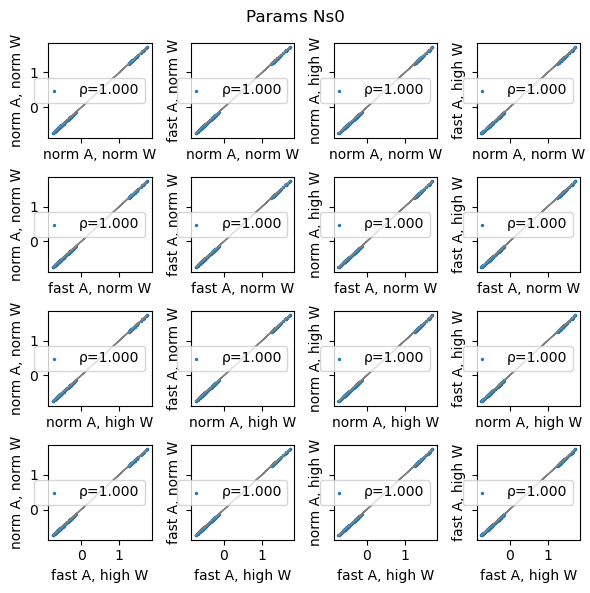

In [15]:
fig, axes = plt.subplots(n_paths, n_paths, sharex=True, sharey=True, figsize=(6,6))

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = params_paths_zerosum[i]["bias_Ns0"].view(-1)
        y = params_paths_zerosum[j]["bias_Ns0"].view(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('Params Ns0')
fig.tight_layout()

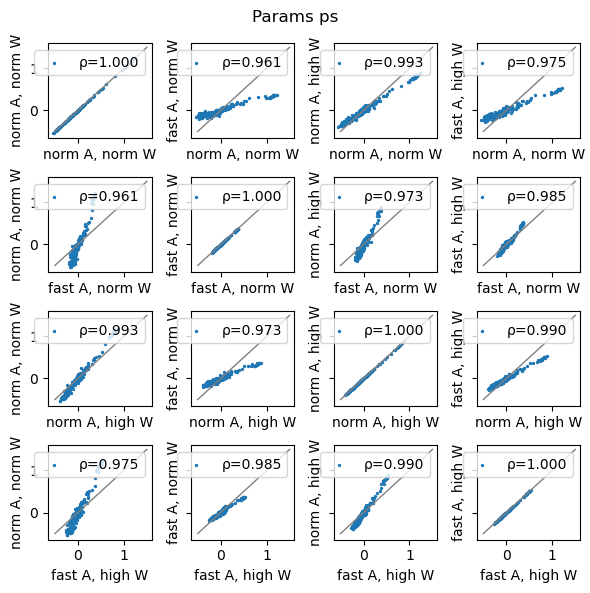

In [16]:
fig, axes = plt.subplots(n_paths, n_paths, sharex=True, sharey=True, figsize=(6,6))
lims = [-0.5,1.5]

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = params_paths_zerosum[i]["bias_ps"].view(-1)
        y = params_paths_zerosum[j]["bias_ps"].view(-1)
        rho = torch.corrcoef(torch.stack((x,y)))[0,1].item()
        ax.scatter(x, y, s=2, label=f'ρ={rho:.3f}')
        ax.legend()
        ax.plot(lims, lims, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('Params ps')
fig.tight_layout()

In [17]:
x = one_hot(sequences[0])

In [18]:
logNs0_paths = []
for i in range(len(paths)):
    params = params_paths_zerosum[i]
    logNs0 = indep_sites.compute_energy(x, {"bias": params["bias_Ns0"]})
    logNs0_paths.append(logNs0)
    print(f"finished {i+1}-th path")

finished 1-th path
finished 2-th path
finished 3-th path
finished 4-th path


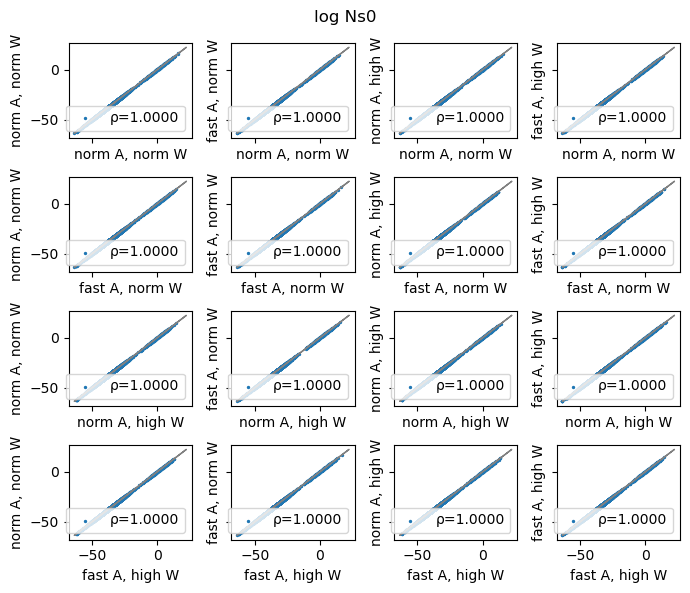

In [19]:
fig, axes = plt.subplots(n_paths, n_paths, 
                         sharex=True, sharey=True, figsize=(7,6)
                        )
N = 10**4

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = logNs0_paths[i]
        y = logNs0_paths[j]
        idx = random.sample(range(len(x)), min(N, len(x)))
        rho = torch.corrcoef(torch.stack((x[idx],y[idx])))[0,1].item()
        ax.scatter(x[idx], y[idx], s=2, label=f'ρ={rho:.4f}')
        ax.legend(loc='lower right')
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('log Ns0')
fig.tight_layout()

In [20]:
x = one_hot(sequences[0])

In [21]:
logps_paths = []
for i in range(len(paths)):
    params = params_paths_zerosum[i]
    logps = indep_sites.compute_energy(x, {"bias": params["bias_ps"]})
    logps_paths.append(logps)
    print(f"finished {i+1}-th path")

finished 1-th path
finished 2-th path
finished 3-th path
finished 4-th path


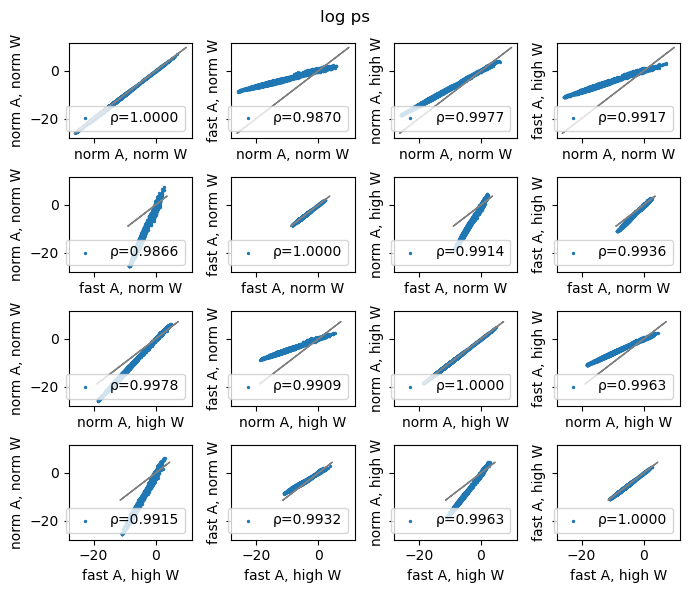

In [31]:
fig, axes = plt.subplots(n_paths, n_paths, 
                         sharex=True, sharey=True, figsize=(7,6)
                        )
N = 10**4
slopes = torch.zeros(n_paths, n_paths)

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = logps_paths[i]
        y = logps_paths[j]
        idx = random.sample(range(len(x)), min(N, len(x)))
        # rho = torch.corrcoef(torch.stack((x[idx],y[idx])))[0,1].item()
        rho = utils.compute_pearson(x[idx], y[idx])
        slopes[i,j] = utils.compute_slope(x[idx], y[idx])
        ax.scatter(x[idx], y[idx], s=2, label=f'ρ={rho:.4f}')
        ax.legend(loc='lower right')
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('log ps')
fig.tight_layout()

In [33]:
absolute_slopes = slopes[0].clone()
absolute_slopes /= absolute_slopes.sum(0, keepdim=True)
absolute_slopes

tensor([0.4014, 0.1341, 0.2909, 0.1736])

In [54]:
import pickle

filename = "paths_indep_sites.pkl"
filepath = "saved/paths_indep_sites/" + filename

data = [experiment_id, round_ids, params]

with open(filepath, 'wb') as f:
    pickle.dump(logps_paths, f)